By: Yifan Wang

# Objective:

After getting the data, the first thing I thought about is: given the taxi data, what business insight can I extract? After thinking for a while, I realized if I was the owner of a taxi company, I would love to know only one question: how can I **increase my profit** or what factors affect my profit by giving this data to my data scientist.

Hence, the objective becomes clear at this point: it is to find some insights on the profit of taxi trips. However, there are no any feature that indicate the profit, what can we do?

In this project:

 - We will clean the data, massage the data to allow for further analysis
 
 
 - It is always true that: **Profit = Revenue - Cost**. Therefore, we will come up with the estimate profit of each trip
 
 
 - Do data **exploration**, **visualization** along with **feature engineering**
 
 
 - We will build **machine learning** models to let the AI predict the profit for us


# Data Cleaning

### Loading Data:

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [2]:

trip_dat = pd.read_csv('TRIP_DATA.csv')

fare_dat = pd.read_csv('FARE_DATA.csv')

### Some Minor Fixing and Sanity Check:

In [3]:
fare_dat.columns = [i.encode('ascii').strip() for i in fare_dat.columns]
trip_dat.columns = [i.encode('ascii').strip() for i in trip_dat.columns]
#Make sure index for each dataset is unique:
assert len(set(trip_dat.index)) == trip_dat.shape[0]
assert len(set(fare_dat.index)) == fare_dat.shape[0]
# Make sure index for both datasets are identical:
assert len([i for i in  trip_dat.index == fare_dat.index if i]) ==  trip_dat.shape[0]

### After the Sanity Check, we are okay to join 2 datasets into one
- in this case doesn't matter inner/left/right/outer join since both datasets have identical row number and index

In [4]:
print('Joining 2 datasets....')
duplicate_cols = [i for i in trip_dat.columns.values if i in fare_dat.columns.values]
for col in duplicate_cols:
    del trip_dat[col]
data = fare_dat.join(trip_dat,how='inner')

Joining 2 datasets....


### Given the large dataset, for efficiency we only use 20% of the data to explore:

In [5]:
np.random.seed(12)
data = data.sample(frac=0.2, replace=False)


### More Several Sanity Checks & Imputation for nans:

- Among all columns there are 2 dtypes: object and float

- For object columns we use isinstance(value,float) to detect nans: looks like in "store_and_fwd_flag" column, we have **47%** of the data are nans. Given the large amount of Nan, I decided to **encode nans** in this column as a category since nans might contain information

- For numeric columns we can simply use np.isnan(value) to check nans: looks like there are less than **100**  Nans in dropoff_longitude and dropoff_latitude. In this case, since very small amount of data doesn't contain location data, we can simply **remove them**

- Then remove 'hack_license' column because it contains too many unique values

- Finally we removed negative values in features such as "trip_time_in_secs"

In [6]:
print('Detecting nans in object cols...')
for c, dtype in zip(data.columns, data.dtypes):
    if dtype == object:
        print(c)
        unique_vals = list(set(data[c]))
        nan_vals = [val for val in unique_vals if isinstance(val,float)]
        nan_vals2 = [val for val in unique_vals if isinstance(val,float)]
        print(nan_vals)

Detecting nans in object cols...
medallion
[]
hack_license
[]
vendor_id
[]
pickup_datetime
[]
payment_type
[]
store_and_fwd_flag
[nan]
dropoff_datetime
[]


In [7]:
# percentage of nans in  'store_and_fwd_flag' column:
prop = sum([isinstance(i,float) for i in data['store_and_fwd_flag']])/float(len(data['store_and_fwd_flag']))
print("%.2f percent of data in store_and_fwd_flag column is nan"%round(prop*100,2))    
    
# encode nan in "store_and_fwd_flag" column:
print('encoding...')
data.ix[[isinstance(i,float) for i in data['store_and_fwd_flag']],'store_and_fwd_flag'] = "-1"

47.54 percent of data in store_and_fwd_flag column is nan
encoding...


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  import sys


In [8]:
print('detecting nan values in numeric columns')
for c, dtype in zip(data.columns, data.dtypes):
    if dtype == np.float64:
        print("Nan number for column %s is %d") %(c,np.sum(np.isnan(data[c]))   )
# Given the huge dataset, it is okay to drop those 209 record:
print('Removing  Nan rows...')
data.dropna(how='any',inplace=True)
# Drop license id:
print('Dropping hack_license col')
del data['hack_license']

detecting nan values in numeric columns
Nan number for column fare_amount is 0
Nan number for column surcharge is 0
Nan number for column mta_tax is 0
Nan number for column tip_amount is 0
Nan number for column tolls_amount is 0
Nan number for column total_amount is 0
Nan number for column trip_distance is 0
Nan number for column pickup_longitude is 0
Nan number for column pickup_latitude is 0
Nan number for column dropoff_longitude is 30
Nan number for column dropoff_latitude is 30
Removing  Nan rows...
Dropping hack_license col


### Time Feautures:

- Based on intuition, time features can be very important in taxi related data;
- Therefore we can confidently extract features such as year,month,day,weekday,hour,minutes of both pickup and drop off time;
- Trip length might also be an interesting feature;
- Since minutes feautures are too specific, I will round them up and combine with hour features

In [9]:
print('Cleanup Time Features...')
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])
# Time Features: pickup features

print('Building new time features...')
print('pickup features...')
print('.')
data['pickup_year'] = data['pickup_datetime'].apply(lambda x: x.year)
print('.')
data['pickup_month'] = data['pickup_datetime'].apply(lambda x: x.month)
print('.')
data['pickup_day'] = data['pickup_datetime'].apply(lambda x: x.day)
print('.')
data['pickup_weekday'] = data['pickup_datetime'].apply(lambda x: x.weekday())
print('.')
data['pickup_hour'] = data['pickup_datetime'].apply(lambda x: x.hour)
print('.')
data['pickup_minute'] = data['pickup_datetime'].apply(lambda x: x.minute)


# Time Features: dropoff features
print('dropoff features...')
print('.')
data['dropoff_year'] = data['dropoff_datetime'].apply(lambda x: x.year)
print('.')
data['dropoff_month'] = data['dropoff_datetime'].apply(lambda x: x.month)
print('.')
data['dropoff_day'] = data['dropoff_datetime'].apply(lambda x: x.day)
print('.')
data['dropoff_weekday'] = data['dropoff_datetime'].apply(lambda x: x.weekday())
print('.')
data['dropoff_hour'] = data['dropoff_datetime'].apply(lambda x: x.hour)
print('.')
data['dropoff_minute'] = data['dropoff_datetime'].apply(lambda x: x.minute)



#Trip Length Feature:
print('.')
trip_len = data['dropoff_datetime'] - data['pickup_datetime']
print('.')
data['trip_length_in_minutes'] = trip_len.astype('timedelta64[m]')
print('.')


#Now it's okay to drop original time cols:
del data['pickup_datetime']
del data['dropoff_datetime']


# Combining hour and minutes:
# For example: hour-2 minutes-20  becomes  2+(20/60) = 2.33
print('Combining hour and minutes...')
data['pickup_hour'] = (data['pickup_hour'] + (data['pickup_minute']/60.0)).round(1)
data['dropoff_hour'] = (data['dropoff_hour'] + (data['dropoff_minute']/60.0)).round(1)
del data['dropoff_minute']
del data['pickup_minute']

Cleanup Time Features...
Building new time features...
pickup features...
.
.
.
.
.
.
dropoff features...
.
.
.
.
.
.
.
.
.
Combining hour and minutes...


### Make sure trip in minutes and trip in seconds features are positive:

In [10]:
data = data[data['trip_time_in_secs']>=0]
data = data[data['trip_length_in_minutes']>=0]

# Target Variable/Label Creation:


 - Although I've never taken a taxi in NYC, it is not hard to find "Passenger must pay all bridge and tunnel tolls. Your receipt will show your total fare including tolls." from http://www.nyc.gov/html/tlc/downloads/pdf/taxi_information.pdf
 
 
 - The approximate gas price of NYC is about $3.8/gallon (http://www.newyorkgasprices.com/retail_price_chart.aspx)
 
 
 - According to some research and readings, I decided to set the MPG for NYC as 20MPG (just approximation). Therefore the gas cost for each trip is:  **  $3.8*(trip_distance/20)  **
 
 
 - Therefore my strategy to calculation the profit for each trip is:
 
 ** profit = total_amount - tolls_amount - mta_tax - gas cost ** (again this is just a approximation, I didn't consider the tips and other cost)


### Before creating "profit" feature, we need to make sure all the data is correct:

- Since the total charge, tolls_amount are the charge amount, it doesn't make sense to have this variable to below 0

In [11]:
# Total amount: 
print(data['total_amount'].describe().astype(int))

# keep record:


# keep records that are above 0:
data = data[data['total_amount']>=0]

count    2611770
mean          14
std           11
min          -55
25%            8
50%           11
75%           16
max          500
Name: total_amount, dtype: int64


In [12]:
# Tolls amount:
print(data['tolls_amount'].describe().astype(int))

# keep records that are above 0:
data = data[data['tolls_amount']>=0]

count    2611739
mean           0
std            1
min            0
25%            0
50%            0
75%            0
max           58
Name: tolls_amount, dtype: int64


In [13]:
# mta_tax amount:
print(data['mta_tax'].describe().astype(int))

# make sure tax is not larger than total amount:
data = data[data['mta_tax']<=data['total_amount']]

count    2611739
mean           0
std            0
min            0
25%            0
50%            0
75%            0
max            0
Name: mta_tax, dtype: int64


In [14]:
# trip distance:

# All good here
print(data['trip_distance'].describe().astype(int))

count    2611738
mean           2
std            3
min            0
25%            1
50%            1
75%            3
max         3008
Name: trip_distance, dtype: int64


In [15]:
data['profit'] = data['total_amount'] - data['tolls_amount'] - data['mta_tax'] - 3.8*(data['trip_distance']/20)

In [16]:
# New variable: profit:
print(data['profit'].describe().astype(int))


# Keep only within +/- 2 standard deviations:

mn = data['profit'].mean()
sd = data['profit'].std()

data = data[data['profit']<= (mn+2*sd) ]
data = data[data['profit']>= (mn-2*sd) ]

count    2611738
mean          13
std           10
min         -547
25%            7
50%           10
75%           15
max          499
Name: profit, dtype: int64


## Attention:

- At this point, I'm more interested to use other features such as time and location to predict the profit, therefore I decided to remove all features that are dollar amount related

- It is also a good practice to do so because this will prevent data leakage


In [17]:

del data['mta_tax']


for i in [col for col in data.columns if 'amount' in col]:
    print('del:'+i)
    del data[i]

del:fare_amount
del:tip_amount
del:tolls_amount
del:total_amount


# Data Visualization & Exploration:

- In this section, I will explore the data, visualize some key features and will perform feature engineering along the way


In [18]:
# plot setup:

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Correlation Plot:

Although eventually we are going to build machine learning models using non-linear models, it is still quite useful to explore the linear relationship between features using correlation plot. Look how fare amount, tip amount, rate code, distance and trip length are correlated with profit


/usr/local/lib/python2.7/site-packages/seaborn/palettes.py:727: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))
/usr/local/lib/python2.7/site-packages/seaborn/palettes.py:727: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


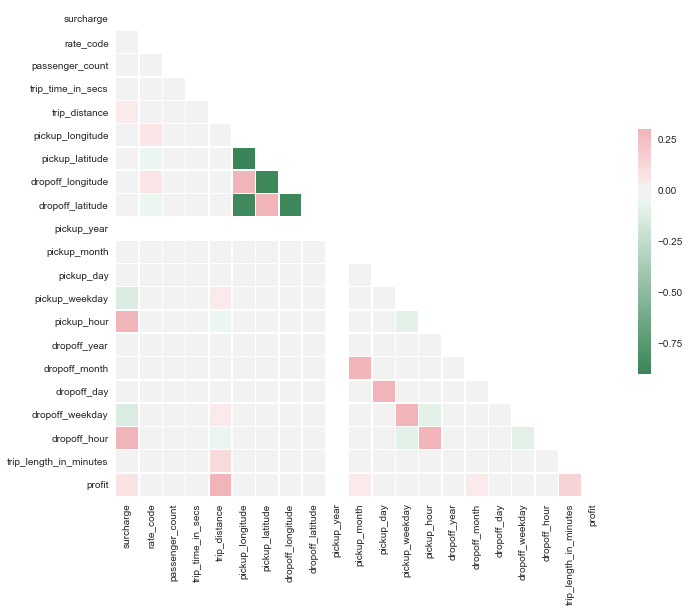

In [19]:
sns.set(style="white")


# correlation matrix
corr = data.corr()
# mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Distribution of Sampled Profit


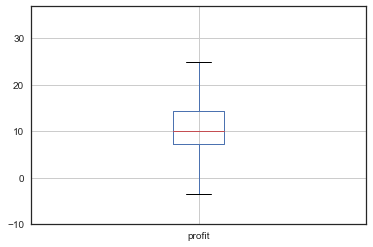

In [20]:
data.boxplot('profit')

### Based on the pickup and dropoff location, we use clustering technique to  create some geo features. 

In [21]:
kmeans1 = KMeans(n_clusters=15, random_state=0).fit(data[['pickup_latitude','pickup_longitude']])


In [22]:
data['geo_pickup_cluster'] = kmeans1.labels_

In [23]:
kmeans2 = KMeans(n_clusters=15, random_state=0).fit(data[['dropoff_latitude','dropoff_longitude']])

data['geo_dropoff_cluster'] = kmeans2.labels_

### Geo Trip Feature:

- now we can create a new feature, I call it 'geo_trip_feature', each will be a pair value that indicate from pickup location to drop off location, so that we can explore which pair of locations are the most beneficial to the taxi.


- For example if the passanger was picked up at cluster 1 and dropped off at cluster 2, our new feature will simply become: "1->2". Don't worry about the value, We can label encode them in the modeling phase.

In [24]:
data['geo_trip'] = data['geo_pickup_cluster'].astype(str)+'->'+data['geo_dropoff_cluster'].astype('str')

### Where Do People Travel the Most:


 11 -> 14
 
 0 -> 0
 
 0 -> 14
 
 11 -> 0

In [25]:
tr_freq = data[['geo_trip']].groupby('geo_trip').size().sort_values(ascending=False)[:10]

pd.DataFrame(tr_freq)

,0
geo_trip,
11->14,943679
0->0,746285
0->14,382050
11->0,361384
1->1,43252
2->2,7804
11->1,1118
0->1,1026
1->14,638


### Which route is the most beneficial?


4 -> 6

11 -> 8

5 -> 0

In [26]:
trip_pr_agg = data[['geo_trip','profit']].groupby('geo_trip').mean()
trip_pr_agg.sort_values(by='profit',ascending=False)[:10]


,profit
geo_trip,
4->6,24.989500
11->8,22.853500
5->0,18.274500
9->6,18.059450
0->11,15.091125
11->0,14.896024
0->6,14.543887
0->14,14.355665
8->0,14.133513


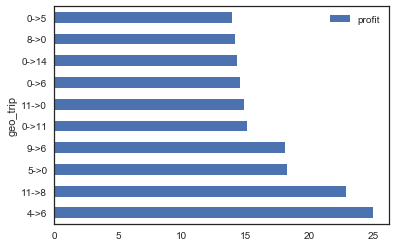

In [27]:
trip_pr_agg.sort_values(by='profit',ascending=False)[:10].plot(kind='barh')

### When is the Peak time?

- Looks like for both pick up and drop off hour, around 20:00pm is the peak time while 5:00am is the off-peak time

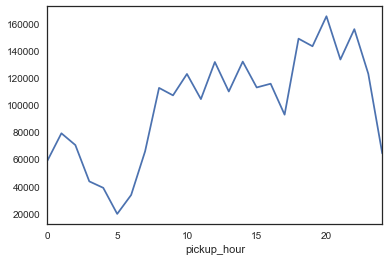

In [28]:
pd.DataFrame(data[['pickup_hour']].round()).groupby('pickup_hour').size().plot()




### When is the Peak Profit Time:

- It is interesting that when it is at the off-peak time 5:00am, average profit is at the peak

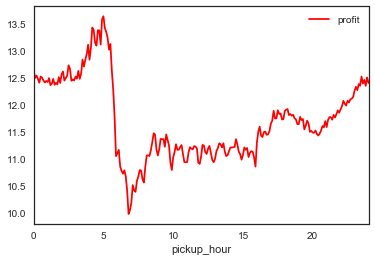

In [29]:
data[['pickup_hour','profit']].groupby('pickup_hour').mean().plot(color='red')




### How about Peak Day of the Week?

- looks like on Monday and Sunday people use less taxi

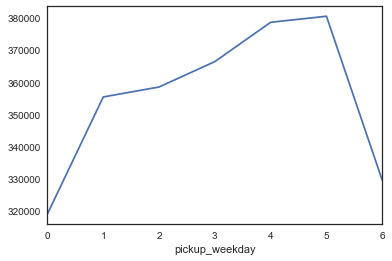

In [30]:
pd.DataFrame(data[['pickup_weekday']].round()).groupby('pickup_weekday').size().plot()



### The most Profitable Weekday?

- Surprisingly on Saturday it is the least beneficial, while on Thursday and Friday it is the most beneficial

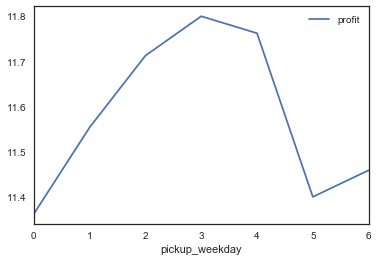

In [31]:
data[['pickup_weekday','profit']].groupby('pickup_weekday').mean().plot()


### Which Weekday-Time Combination is the most beneficial?

- To answer this question we need to again concatenate "weekday" and "hour" feature, and then groupby each weekday-time combination and find the highest average profit


- The most beneficial time is 5am on Monday


- The second beneficial time is 5am on Wednesday


- The third beneficial time is 5am on Friday


- Basically anyday's early morning is a good time to make money

In [32]:
data['weekday_hour'] =\
data['pickup_weekday'].astype(str) +\
'-'+\
data['pickup_hour'].round().astype(int).astype(str)

In [35]:
data[[
    'weekday_hour',
    'profit']].groupby('weekday_hour').mean().sort_values(by='profit',ascending=False)[:10]

,profit
weekday_hour,
0-5,14.549068
4-5,13.764461
3-5,13.348043
0-4,13.309028
2-5,13.240159
2-4,13.215606
6-5,13.145547
1-4,13.050125
3-4,13.043122


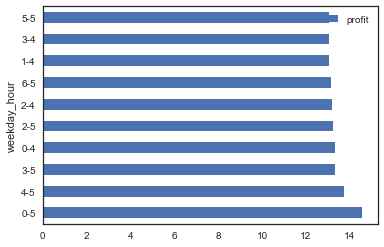

In [36]:
data[[
    'weekday_hour',
    'profit']].groupby('weekday_hour').mean().sort_values(
    by='profit',
    ascending=False)[:10].plot(kind='barh')

###  Top 10 Most Profitable Taxis

- the IDs were hacked so this doesn't have too much value

In [37]:
data[['medallion', 'profit']].groupby('medallion').mean().sort_values('profit',ascending=False)[:10]

,profit
medallion,
C89B3EC15CEC5EBF70DF5B23D7710F9E,16.945815
54AB418CE374F7CFC1A83B69BBFF2830,15.826076
8F4D9A07E1A3A6E4AE79A83490B927C6,14.923208
6BA106B588787D5B46D1BD358979A094,14.274705
8D20EDAB545FEC4586819668027855E3,14.171473
40A21AEA612376C62D1CB5308D4A4E58,14.120447
83C10B024D87A293958052BD1CA54AB2,13.919445
85082FDC26968800BBF5E381DBE57CE0,13.844066
3C4E85EE0BACAD3A758C153734111147,13.730975


### Which weekday has more passengers?

- Note that 0 is Monday and 6 is Sunday

- From Monday to Weekend, the mean number of passengers for each trip is increasing

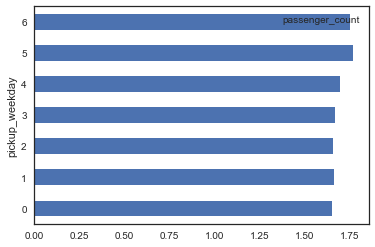

In [38]:
data[['pickup_weekday', 'passenger_count']].groupby('pickup_weekday').mean().plot(kind='barh')

# Modeling



- My strategy of model training is first get the baseline of individual models(meta learners). I will consider 2 factors when choosing single models. First, it has to be trained fast (that's why I won't choose algos such as SVM which is infamous for its low speed); Second, it has to be very different from other models, I will tell you why I do this below. For each model, I will try to fin-tune it (not guaranteed given the limited time).

- After trained each individual model, I will wrap up by create a ** super learner ** using state-of-art stacking technique, which can hopefully boost the accuracy.


In [39]:
# Some helper function:
def rmse(pred, label):
    return np.sqrt(((pred - label) ** 2).mean())

### Optimizing Training Data Size using Learning Curve:

- From our exploration, it doesn't look necessary to use all of the data to train the model. Then how to select the optimized size of training example? I believe we can plot the **learning curve** to find the best training size


- Look like keep adding training examples helps the model performs better. However, after 400,000 training examples the RMSE slope becomes  flatter, also for the sake of time efficiency, as well as because this is just for demonstration, I decided to use  data for training


In [42]:
size_list = []
cv_res_list =[]


for n_training in [10000,25000,120000,600000,1000000,1500000,2400000]:
    np.random.seed(1028)
    samp = data.sample(n=n_training, replace=False)
    print(samp.shape)
    # Label encoding obj vars:
    for c in samp.dtypes[samp.dtypes == object].index.values:
        lb_enc = LabelEncoder()
        samp[c] = lb_enc.fit_transform(samp[c])
        print(c)
    # train test split:
    tr_r = int(len(samp)*0.8)
    train = samp[:tr_r]
    test = samp[tr_r:]
    y_train = train['profit']
    y_test = test['profit']
    del train['profit']
    del test['profit']
    ###Train:
    y_mean = samp['profit'].mean()
    
    xgb_params = {
        'eta': 0.3, #0.3 just for fast converge, actual training should be lower
        'max_depth': 9,
        'subsample': 0.80,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'base_score': y_mean,
        'silent': 1,
        'booster':'gbtree'
    }
    dtrain = xgb.DMatrix(train, y_train)
    dtest = xgb.DMatrix(test,y_test)
    watchlist  = [ (dtrain,'train'),(dtest,'eval')]
    model = xgb.train(xgb_params, dtrain, 1000, watchlist, early_stopping_rounds=10) 
     
        
    size_list.append(n_training)
    cv_res_list.append(model.best_score)
    print("CV result for %d size is %f")%(n_training,model.best_score)


(10000, 29)
medallion
vendor_id
payment_type
store_and_fwd_flag
geo_trip
weekday_hour
[0]	train-rmse:4.3581	eval-rmse:4.46506
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:3.1594	eval-rmse:3.26166
[2]	train-rmse:2.32286	eval-rmse:2.46321
[3]	train-rmse:1.73702	eval-rmse:1.93728
[4]	train-rmse:1.34008	eval-rmse:1.62672
[5]	train-rmse:1.06857	eval-rmse:1.43108
[6]	train-rmse:0.886716	eval-rmse:1.31966
[7]	train-rmse:0.763608	eval-rmse:1.26847
[8]	train-rmse:0.682155	eval-rmse:1.23597
[9]	train-rmse:0.622268	eval-rmse:1.22225
[10]	train-rmse:0.574661	eval-rmse:1.21684
[11]	train-rmse:0.544481	eval-rmse:1.21102
[12]	train-rmse:0.517714	eval-rmse:1.21131
[13]	train-rmse:0.497463	eval-rmse:1.21384
[14]	train-rmse:0.483616	eval-rmse:1.21633
[15]	train-rmse:0.474061	eval-rmse:1.21548
[16]	train-rmse:0.461338	eval-rmse:1.21381
[17]	train-rmse:0.453442	eval-rmse:1.21551
[18]	train-rmse

[11]	train-rmse:0.936189	eval-rmse:1.0361
[12]	train-rmse:0.92572	eval-rmse:1.02958
[13]	train-rmse:0.916534	eval-rmse:1.02361
[14]	train-rmse:0.910497	eval-rmse:1.02135
[15]	train-rmse:0.905193	eval-rmse:1.01728
[16]	train-rmse:0.901092	eval-rmse:1.01573
[17]	train-rmse:0.895188	eval-rmse:1.01321
[18]	train-rmse:0.893043	eval-rmse:1.01274
[19]	train-rmse:0.890352	eval-rmse:1.01252
[20]	train-rmse:0.887802	eval-rmse:1.01152
[21]	train-rmse:0.884313	eval-rmse:1.0107
[22]	train-rmse:0.882189	eval-rmse:1.01015
[23]	train-rmse:0.878508	eval-rmse:1.00942
[24]	train-rmse:0.875039	eval-rmse:1.00699
[25]	train-rmse:0.873304	eval-rmse:1.00697
[26]	train-rmse:0.87158	eval-rmse:1.00614
[27]	train-rmse:0.87023	eval-rmse:1.00563
[28]	train-rmse:0.868607	eval-rmse:1.00551
[29]	train-rmse:0.86689	eval-rmse:1.00563
[30]	train-rmse:0.86572	eval-rmse:1.00554
[31]	train-rmse:0.864355	eval-rmse:1.00537
[32]	train-rmse:0.863015	eval-rmse:1.00477
[33]	train-rmse:0.859794	eval-rmse:1.00359
[34]	train-rmse:0.

[32]	train-rmse:0.896431	eval-rmse:0.980139
[33]	train-rmse:0.892742	eval-rmse:0.978449
[34]	train-rmse:0.891874	eval-rmse:0.978096
[35]	train-rmse:0.890528	eval-rmse:0.977368
[36]	train-rmse:0.888897	eval-rmse:0.976553
[37]	train-rmse:0.887632	eval-rmse:0.976496
[38]	train-rmse:0.887218	eval-rmse:0.976638
[39]	train-rmse:0.886594	eval-rmse:0.976925
[40]	train-rmse:0.883599	eval-rmse:0.9763
[41]	train-rmse:0.882492	eval-rmse:0.976466
[42]	train-rmse:0.880512	eval-rmse:0.975847
[43]	train-rmse:0.879956	eval-rmse:0.975727
[44]	train-rmse:0.877977	eval-rmse:0.97573
[45]	train-rmse:0.876523	eval-rmse:0.975762
[46]	train-rmse:0.875383	eval-rmse:0.975867
[47]	train-rmse:0.874964	eval-rmse:0.97571
[48]	train-rmse:0.87279	eval-rmse:0.975186
[49]	train-rmse:0.872177	eval-rmse:0.975133
[50]	train-rmse:0.870363	eval-rmse:0.97468
[51]	train-rmse:0.869391	eval-rmse:0.974511
[52]	train-rmse:0.867701	eval-rmse:0.974029
[53]	train-rmse:0.867424	eval-rmse:0.974064
[54]	train-rmse:0.866744	eval-rmse:0.9

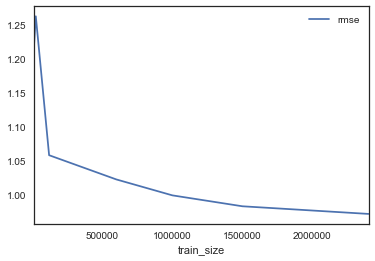

In [43]:
learn_curve = pd.DataFrame({
    'train_size': size_list,
    'rmse': cv_res_list
})


learn_curve.plot(x='train_size',y='rmse')

### Ensemble Models:

 - To boost the performance of models, we apply state of art stacking method to create a super learner. 
 
 - Given the limited time, I will only create 2 meta learner and wrap up with a neural network using Tensorflow

In [44]:
# Initialize:
model_list = ['xgb_tree','lightgbm','ensemble_NN']


In [45]:
model_rmse = [0]*3

In [52]:
# Randomly Sample:
np.random.seed(11)
samp = data.sample(n=2400000, replace=False)

#Label Encoding:
for c in samp.dtypes[samp.dtypes == object].index.values:
    lb_enc = LabelEncoder()
    samp[c] = lb_enc.fit_transform(samp[c])
    print(c)

# train test split:

train = samp[:1900000]
valid = samp[1900000:2300000]
test = samp[2300000:]

y_train = train['profit']
y_valid = valid['profit']
y_test = test['profit']
del train['profit']
del valid['profit']
del test['profit']

print('train shape:')
print(train.shape)
print('valid shape:')
print(valid.shape)
print('test shape:')
print(test.shape)

medallion
vendor_id
payment_type
store_and_fwd_flag
geo_trip
weekday_hour
train shape:
(1900000, 28)
valid shape:
(400000, 28)
test shape:
(100000, 28)


### Level 1 Meta Learner 1: XGBOOST_GBTREE:

- This algorithm uses regression tree as the base learner

In [58]:

###Train:
y_mean = y_train.mean()

xgb_params = {
    'eta': 0.1, #0.1 just for demonstration, for performance should be less than 0.05
    'max_depth': 9,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean,
    'silent': 1,
    'booster':'gbtree'
}

dtrain = xgb.DMatrix(train, y_train)
dtrain2 = xgb.DMatrix(train)

dvali = xgb.DMatrix(valid, y_valid)
dtest = xgb.DMatrix(test)


In [59]:
# print('start training...')

watchlist  = [ (dtrain,'train'),(dvali,'eval')]

 
model = xgb.train(xgb_params, dtrain, 1000, watchlist, early_stopping_rounds=10) 

[0]	train-rmse:5.58817	eval-rmse:5.59481
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:5.05319	eval-rmse:5.05981
[2]	train-rmse:4.57346	eval-rmse:4.58017
[3]	train-rmse:4.14384	eval-rmse:4.15081
[4]	train-rmse:3.75936	eval-rmse:3.76671
[5]	train-rmse:3.41577	eval-rmse:3.42391
[6]	train-rmse:3.10953	eval-rmse:3.11854
[7]	train-rmse:2.83649	eval-rmse:2.84658
[8]	train-rmse:2.5936	eval-rmse:2.60489
[9]	train-rmse:2.37813	eval-rmse:2.39083
[10]	train-rmse:2.1877	eval-rmse:2.20221
[11]	train-rmse:2.02001	eval-rmse:2.03649
[12]	train-rmse:1.87256	eval-rmse:1.89108
[13]	train-rmse:1.74312	eval-rmse:1.76378
[14]	train-rmse:1.62994	eval-rmse:1.65284
[15]	train-rmse:1.53171	eval-rmse:1.5569
[16]	train-rmse:1.44639	eval-rmse:1.47426
[17]	train-rmse:1.37261	eval-rmse:1.40337
[18]	train-rmse:1.30902	eval-rmse:1.34234
[19]	train-rmse:1.25469	eval-rmse:1.29055
[20]	train-rmse:1.20814	eval-r

[185]	train-rmse:0.837704	eval-rmse:0.973848
[186]	train-rmse:0.83765	eval-rmse:0.973835
[187]	train-rmse:0.837238	eval-rmse:0.973807
[188]	train-rmse:0.837146	eval-rmse:0.973703
[189]	train-rmse:0.836787	eval-rmse:0.973601
[190]	train-rmse:0.836133	eval-rmse:0.973372
[191]	train-rmse:0.835991	eval-rmse:0.973374
[192]	train-rmse:0.835697	eval-rmse:0.973289
[193]	train-rmse:0.835237	eval-rmse:0.973047
[194]	train-rmse:0.835043	eval-rmse:0.972925
[195]	train-rmse:0.834988	eval-rmse:0.972931
[196]	train-rmse:0.834649	eval-rmse:0.97289
[197]	train-rmse:0.834354	eval-rmse:0.972825
[198]	train-rmse:0.834224	eval-rmse:0.972758
[199]	train-rmse:0.833665	eval-rmse:0.972686
[200]	train-rmse:0.833498	eval-rmse:0.972596
[201]	train-rmse:0.833257	eval-rmse:0.972552
[202]	train-rmse:0.833066	eval-rmse:0.97255
[203]	train-rmse:0.83232	eval-rmse:0.972336
[204]	train-rmse:0.831916	eval-rmse:0.972346
[205]	train-rmse:0.831586	eval-rmse:0.972304
[206]	train-rmse:0.831526	eval-rmse:0.972278
[207]	train-rm

[368]	train-rmse:0.791531	eval-rmse:0.966339
[369]	train-rmse:0.791151	eval-rmse:0.966259
[370]	train-rmse:0.790974	eval-rmse:0.966278
[371]	train-rmse:0.790675	eval-rmse:0.966242
[372]	train-rmse:0.790329	eval-rmse:0.966253
[373]	train-rmse:0.790228	eval-rmse:0.966279
[374]	train-rmse:0.789998	eval-rmse:0.966208
[375]	train-rmse:0.789853	eval-rmse:0.966204
[376]	train-rmse:0.789608	eval-rmse:0.966152
[377]	train-rmse:0.789251	eval-rmse:0.966008
[378]	train-rmse:0.788798	eval-rmse:0.96589
[379]	train-rmse:0.788333	eval-rmse:0.965775
[380]	train-rmse:0.788158	eval-rmse:0.965769
[381]	train-rmse:0.787912	eval-rmse:0.965805
[382]	train-rmse:0.787744	eval-rmse:0.965836
[383]	train-rmse:0.787602	eval-rmse:0.965773
[384]	train-rmse:0.787491	eval-rmse:0.96575
[385]	train-rmse:0.787457	eval-rmse:0.96572
[386]	train-rmse:0.787175	eval-rmse:0.965638
[387]	train-rmse:0.787017	eval-rmse:0.965677
[388]	train-rmse:0.786988	eval-rmse:0.965692
[389]	train-rmse:0.786707	eval-rmse:0.965715
[390]	train-r

In [60]:
imp = sorted(model.get_fscore().items(), key=lambda x: x[1],reverse=True)
imp


[('trip_time_in_secs', 17404),
 ('medallion', 15249),
 ('trip_distance', 15208),
 ('pickup_longitude', 9382),
 ('dropoff_longitude', 8754),
 ('dropoff_latitude', 8747),
 ('pickup_latitude', 8493),
 ('pickup_hour', 5790),
 ('payment_type', 5430),
 ('pickup_month', 4471),
 ('pickup_day', 4319),
 ('weekday_hour', 4296),
 ('surcharge', 3617),
 ('dropoff_hour', 2894),
 ('trip_length_in_minutes', 2031),
 ('passenger_count', 1797),
 ('rate_code', 1747),
 ('vendor_id', 1641),
 ('pickup_weekday', 1223),
 ('store_and_fwd_flag', 640),
 ('geo_trip', 529),
 ('dropoff_day', 369),
 ('geo_dropoff_cluster', 214),
 ('dropoff_month', 164),
 ('geo_pickup_cluster', 160),
 ('dropoff_weekday', 130),
 ('dropoff_year', 1)]

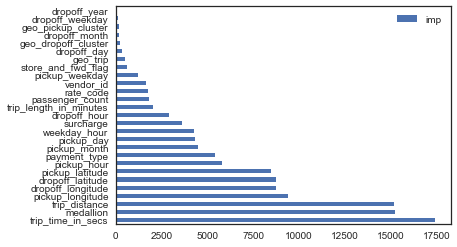

In [61]:
imp_dat = pd.DataFrame({ 'imp': [i[1] for i in imp]},index=[i[0] for i in imp])

imp_dat.plot(kind='barh')

In [62]:
xgb_pred = model.predict(dtest)
stack_feat1 = model.predict(dtrain2)



In [63]:

rmse1 = rmse(pred=xgb_pred,label=y_test)
print('RMSE:%f'%rmse1)


RMSE:0.946071


In [64]:
model_rmse[0] = rmse1

In [65]:
res = pd.DataFrame({'pred': xgb_pred,'label': y_test})

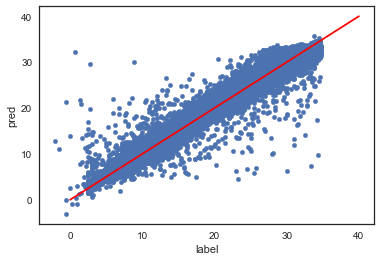

In [66]:
ax = res.plot(kind='scatter',x='label',y='pred')
plt.plot( [0,40],[0,40],color='red' )


### Level 1 Meta Learner 2: Xgboost - gblinear



In [68]:
import lightgbm as lgb

l_train = lgb.Dataset(train, label=y_train)
l_valid = lgb.Dataset(valid, label=y_valid)
l_test= lgb.Dataset(test, label=None)
watchlist = [l_valid]

In [71]:



##### RUN LIGHTGBM

params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.2
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l2'          # or 'mae'
params['sub_feature'] = 0.5      # feature_fraction -- OK, back to .5, but maybe later increase this
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0

print("\nFitting LightGBM model ...")
clf = lgb.train(params, l_train, 1000, watchlist,early_stopping_rounds=10)



Fitting LightGBM model ...
[1]	valid_0's l2: 25.451
Train until valid scores didn't improve in 10 rounds.
[2]	valid_0's l2: 16.7986
[3]	valid_0's l2: 11.5232
[4]	valid_0's l2: 8.37601
[5]	valid_0's l2: 5.82855
[6]	valid_0's l2: 4.38956
[7]	valid_0's l2: 3.44279
[8]	valid_0's l2: 2.8561
[9]	valid_0's l2: 2.34358
[10]	valid_0's l2: 2.17199
[11]	valid_0's l2: 1.93212
[12]	valid_0's l2: 1.69134
[13]	valid_0's l2: 1.52998
[14]	valid_0's l2: 1.46527
[15]	valid_0's l2: 1.41454
[16]	valid_0's l2: 1.351
[17]	valid_0's l2: 1.32358
[18]	valid_0's l2: 1.31041
[19]	valid_0's l2: 1.27978
[20]	valid_0's l2: 1.24482
[21]	valid_0's l2: 1.22187
[22]	valid_0's l2: 1.21507
[23]	valid_0's l2: 1.21046
[24]	valid_0's l2: 1.19333
[25]	valid_0's l2: 1.18426
[26]	valid_0's l2: 1.17459
[27]	valid_0's l2: 1.16244
[28]	valid_0's l2: 1.15767
[29]	valid_0's l2: 1.15487
[30]	valid_0's l2: 1.1529
[31]	valid_0's l2: 1.1509
[32]	valid_0's l2: 1.14107
[33]	valid_0's l2: 1.13822
[34]	valid_0's l2: 1.13048
[35]	valid_0's 

[294]	valid_0's l2: 0.994837
[295]	valid_0's l2: 0.994548
[296]	valid_0's l2: 0.994429
[297]	valid_0's l2: 0.994334
[298]	valid_0's l2: 0.994382
[299]	valid_0's l2: 0.994326
[300]	valid_0's l2: 0.994108
[301]	valid_0's l2: 0.99419
[302]	valid_0's l2: 0.994394
[303]	valid_0's l2: 0.994432
[304]	valid_0's l2: 0.994447
[305]	valid_0's l2: 0.994213
[306]	valid_0's l2: 0.994234
[307]	valid_0's l2: 0.994247
[308]	valid_0's l2: 0.9942
[309]	valid_0's l2: 0.994212
[310]	valid_0's l2: 0.994218
Early stopping, best iteration is:
[300]	valid_0's l2: 0.994108


In [72]:
print('predicting...')
lgb_res = clf.predict(test.values.astype(np.float32, copy=False))
print('.')
stack_feat2 = clf.predict(train.values.astype(np.float32, copy=False))

predicting...
.


In [75]:
rmse2 = rmse(lgb_res,y_test)
model_rmse[1] = rmse2
print(rmse2)

0.979102668028


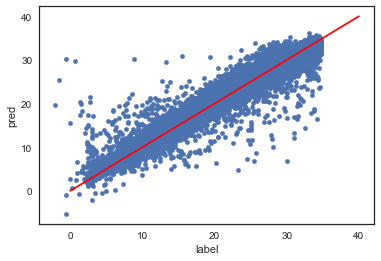

In [74]:
res2 = pd.DataFrame({'pred': lgb_res,'label': y_test})
ax = res2.plot(kind='scatter',x='label',y='pred')
plt.plot( [0,40],[0,40],color='red' )


## Stacking using Multi-layer Perceptron NN

- using tensorflow

In [76]:
l2_train = pd.DataFrame({
    'ft1':stack_feat1,
    'ft2':stack_feat2
     })


l2_test = pd.DataFrame({
    'ft1':xgb_pred,
    'ft2':lgb_res
    
})

tf_train = l2_train.values
tf_test = l2_test.values
y_train = y_train.astype('float32')

y_test = y_test.astype('float32')


In [77]:
import tensorflow as tf
# Configuration:
N_FEATURE = 2
LEARNING_RATE = 0.0005

n_hidden_1 = 6 # 1st layer number of features
n_hidden_2 = 12 # 2nd layer number of features
n_hidden_3 = 24 # 3nd layer number of features




#Building the graph:
# Input
x = tf.placeholder("float",shape=[None,N_FEATURE],name='x_input')
y_ = tf.placeholder("float",shape=[None,1],name='y_input')


#Layer 1:
w1 = tf.Variable(tf.truncated_normal([N_FEATURE,n_hidden_1],stddev=0.01))  #weight
b1= tf.Variable(tf.constant(0.01,shape=[n_hidden_1])) #bias
matmul_1 = tf.add(tf.matmul(x, w1),b1,name='add1')
relu_1 = tf.nn.relu(matmul_1) # non-linear transform

#Layer 2:
w2 = tf.Variable(tf.truncated_normal([n_hidden_1,n_hidden_2],stddev=0.01))  #weight
b2= tf.Variable(tf.constant(0.01,shape=[n_hidden_2])) #bias
matmul_2 = tf.add(tf.matmul(relu_1, w2), b2)
relu_2 = tf.nn.relu(matmul_2)

#Layer 3:
w3 = tf.Variable(tf.truncated_normal([n_hidden_2,n_hidden_3],stddev=0.01))  #weight
b3= tf.Variable(tf.constant(0.01,shape=[n_hidden_3])) #bias
matmul_3 = tf.add(tf.matmul(relu_2, w3), b3)
relu_3 = tf.nn.relu(matmul_3)




# Output Layer:
w_out = tf.Variable(tf.truncated_normal([n_hidden_3, 1],stddev=0.01))  #weight
b_out= tf.Variable(tf.constant(0.01,shape=[1])) #bias
y = tf.matmul(relu_3, w_out)+b_out



#Cost:
cost = tf.sqrt(tf.reduce_mean(tf.squared_difference(y, y_))) #mae defined here
#Optimizer:
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)



In [78]:
batch_size  = 1000
training_epochs = 15
total_len = len(tf_train)


# Launch the graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(total_len/batch_size)
        # Loop over all batches
        for i in range(total_batch-1):
            batch_x = tf_train[i*batch_size:(i+1)*batch_size]
            batch_y = y_train[i*batch_size:(i+1)*batch_size].values.reshape([-1,1])
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c, p = sess.run([optimizer, cost, y], feed_dict={x: batch_x,
                                                          y_: batch_y})
            # Compute average loss
            avg_cost += c / total_batch


        # Display logs per epoch step
        if epoch % 1 == 0:
            print ("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.4f}".format(avg_cost))
            print ("[*]----------------------------")


    print ("Optimization Finished!")
    # Predict test data:
    tf_pred = y.eval(feed_dict={x:tf_test })
#     tf_feat = y.eval(feed_dict={x:tf_train })

('Epoch:', '0001', 'cost=', '1.7449')
[*]----------------------------
('Epoch:', '0002', 'cost=', '0.7806')
[*]----------------------------
('Epoch:', '0003', 'cost=', '0.7791')
[*]----------------------------
('Epoch:', '0004', 'cost=', '0.7788')
[*]----------------------------
('Epoch:', '0005', 'cost=', '0.7788')
[*]----------------------------
('Epoch:', '0006', 'cost=', '0.7788')
[*]----------------------------
('Epoch:', '0007', 'cost=', '0.7787')
[*]----------------------------
('Epoch:', '0008', 'cost=', '0.7787')
[*]----------------------------
('Epoch:', '0009', 'cost=', '0.7787')
[*]----------------------------
('Epoch:', '0010', 'cost=', '0.7787')
[*]----------------------------
('Epoch:', '0011', 'cost=', '0.7787')
[*]----------------------------
('Epoch:', '0012', 'cost=', '0.7787')
[*]----------------------------
('Epoch:', '0013', 'cost=', '0.7787')
[*]----------------------------
('Epoch:', '0014', 'cost=', '0.7787')
[*]----------------------------
('Epoch:', '0015', '

In [79]:
# test mae here:
rmse3 = rmse(tf_pred.reshape((-1,1)),y_test.values.reshape((-1,1)))
#need to reshape f_pred probably
print(rmse3)

0.941477


In [80]:
model_rmse[2] = rmse3

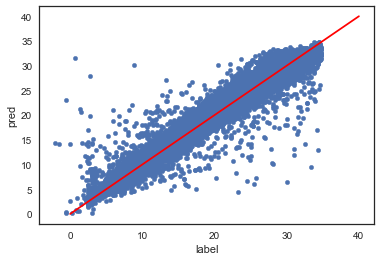

In [81]:

res4 = pd.DataFrame({'pred': tf_pred.reshape((-1,)),'label': y_test.values.reshape((-1,))})
ax = res4.plot(kind='scatter',x='label',y='pred')
plt.plot( [0,40],[0,40],color='red' )




## Evaluation

Looks like ensembling by NN can further decrease the error (although not too much)

In [82]:
result = pd.DataFrame({'rmse':model_rmse},index=model_list)

In [83]:
result

,rmse
xgb_tree,0.946071
lightgbm,0.979103
ensemble_NN,0.941477


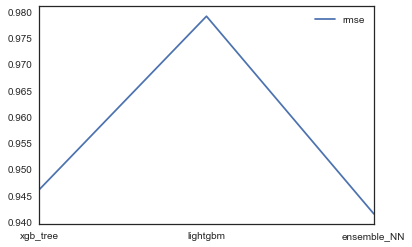

In [86]:
result.plot(kind='line')

# Summary:

In this project, we explored the NYC taxi and discovered several interesting insights. More importantly, we used cutting-edge machine learning algorithms such as xgboost, lightgbm and neural network to predict the profit of each taxi trip. Then weapplied state of the art ensemble techniques such as stacking to further improve the accuracy.

Assume when some day each taxi driver has a AI assistant helps him/her estimate the profit of each potential trip, the driver as well as the taxi company can easily optimize their strategy to incease operation profit.